# Data Analysis Search Results

Our analysis centered around comparing these two metrics:

\begin{align}
products_{Amazon} = \frac{N_{Amazon\ product\ slots}}{N_{product\ slots}}
\end{align}

\begin{align}
{\# 1\ spot}_{Amazon} = \frac{N_{Amazon\ \#1\ slots}}{N_{\#1\ slots}}
\end{align}

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import glob
import time
from collections import Counter
import json
from multiprocessing import Pool

from tqdm import tqdm
from lxml import html
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
from sklearn.utils import resample

from utils import value_counts, calculate_table, calculate_table_not_unique

In [3]:
# inputs
data_dir = '../data/intermediary'
fn_search = f'{data_dir}/searches.csv.gz'
fn_products = f'{data_dir}/products_with_meta.csv.xz'
fn_queries = '../data/input/combined_queries_with_source.csv'
fn_amazon = f'{data_dir}/amazon_private_label.csv.xz'

# intermediary
fn_compare = f'{data_dir}/quality_and_sales_comparisons.csv'

# outputs
output_dir = '../data/output'
fn_top_searches = f'{data_dir}/top_searches.csv.gz'
fn_generic_searches = f'{data_dir}/generic_searches.csv.gz'
fig3 = f'{output_dir}/figures/fig3.png'
fig4 = f'{output_dir}/figures/fig4.png'
fig5a = f'{output_dir}/figures/fig5a.png'
fig5b = f'{output_dir}/figures/fig5b.png'
fig6a = f'{output_dir}/figures/fig6a.png'
fig6b = f'{output_dir}/figures/fig6b.png'
table1 = f'{output_dir}/tables/table1.csv'
for subdir in ['figures', 'tables']:
    os.makedirs(f'{output_dir}/{subdir}', exist_ok=True)

In [5]:
df_amazon = pd.read_csv(fn_amazon, compression='xz')
df_products = pd.read_csv(fn_products, compression='xz')
df_search = pd.read_csv(fn_search, compression='gzip')
keywords = pd.read_csv(fn_queries)

In [7]:
amazon_asin = set(df_amazon.asin.tolist())
len(amazon_asin)

137420

## merge data

In [8]:
_df_search = df_search[df_search.product_type.isin(['regular_placement'])]

searches_with_amazon_brands = _df_search[
    _df_search.asin.isin(amazon_asin)
].search_term.unique()
len(searches_with_amazon_brands)

4567

In [9]:
_df_search = _df_search[_df_search.search_term.isin(searches_with_amazon_brands)].merge(df_products, how='left')
_df_search['is_amazon'] = _df_search.asin.isin(amazon_asin)

In [10]:
_df_search.iloc[0]

asin                                                              B086VR2KY8
product_name               All-New Toshiba 50LF621U21 50-inch Smart 4K UH...
stars                                                                    4.6
reviews                                                                 5282
brand                                                                    NaN
product_url                /gp/slredirect/picassoRedirect.html/ref=pa_sp_...
is_prime                                                                True
is_fresh                                                               False
is_sponsored                                                           False
is_featured_brand                                                       True
is_amazons_choice                                                      False
is_best_seller                                                         False
product_order                                                              1

In [11]:
_df_search["is_shipped_by_amazon_TRUE"] = _df_search.apply(lambda x: any([x['is_shipped_by_amazon'], 
                                x['is_fresh'], x['is_prime']]), axis=1)

In [12]:
kw_generic = keywords[keywords['source'] == 'generic'].search_term
kw_seller = keywords[keywords['source'] == 'seller'].search_term
kw_autocomplete = keywords[keywords['source'].isin(
    ['autocomplete amazon', 'autocomplete walmart']
)].search_term

In [13]:
top_searches = set(kw_autocomplete.tolist() + kw_seller.tolist())
len(top_searches)

11342

In [14]:
df_top = _df_search[
    _df_search.search_term.isin(top_searches)
]
len(df_top), df_top.search_term.nunique()

(187534, 3492)

In [15]:
# how many searches had Amazon?
df_top.search_term.nunique() / len(top_searches)

0.30788220772350555

In [16]:
# how many products?
df_top.asin.nunique()

125769

In [17]:
df_top[df_top.product_order == 1].search_term.nunique()

3492

In [18]:
if not os.path.exists(fn_top_searches):
    df_top.to_csv(fn_top_searches, index=False, compression='gzip')

In [19]:
df_generic = _df_search[
   _df_search.search_term.isin(kw_generic)
]
len(df_generic), df_generic.search_term.nunique()

(69287, 1217)

In [20]:
if not os.path.exists(fn_generic_searches):
    df_generic.to_csv(fn_generic_searches, index=False, compression='gzip')

## Aggregate data

In [21]:
df = df_top

In [22]:
value_counts(df.drop_duplicates(subset=['asin']), col='is_amazon')

,count,percentage
False,119866,0.953065
True,5903,0.046935


In [23]:
# Produce plots

In [24]:
max_rank = 60
n_samples = df.search_term.nunique()
n_products = df.asin.nunique()

In [25]:
df_s = df[df.is_sponsored == True]
df_ns = df[df.is_sponsored == False]

In [26]:
n_samples_sold = df[~df.sold_by.isnull()].search_term.nunique()
n_samples_shipped = df[~df.shipped_by.isnull()].search_term.nunique()

n_products_sold = df[~df.sold_by.isnull()].asin.nunique()
n_products_shipped = df[~df.shipped_by.isnull()].asin.nunique()

In [27]:
df_amazon = df_ns[df_ns.asin.isin(amazon_asin)]
df_non_amazon = df_ns[(~df_ns.asin.isin(amazon_asin))]

df_non_amazon_non_sold_ = df_ns[(~df_ns.asin.isin(amazon_asin)) & 
                               (df_ns.is_sold_by_amazon == False) &
                               (df_ns.is_fresh == False)
                              ]


In [28]:
df_non_amazon_sold_by_amazon_ = df_ns[
        (~df_ns.asin.isin(amazon_asin)) & 
        (df_ns.is_sold_by_amazon == True)
    ]

In [29]:
df_amazon_brand_ = df_ns[df_ns.asin.isin(amazon_asin)]
df_non_amazon_brand_ = df_ns[
    ~df_ns.asin.isin(df_amazon.asin)
]

df_amazon_sold_ = df_ns[df_ns.is_sold_by_amazon == True]
df_not_amazon_sold_ = df_ns[df_ns.is_sold_by_amazon != True]

df_prime_ =  df_ns[
    (df_ns.is_prime == True) | 
    (df_ns.is_fresh == True)
]

df_non_amazon_ = df_ns[
    (~df_ns.asin.isin(amazon_asin))
  & (df_ns.is_sold_by_amazon == False)
  & (df_ns.is_shipped_by_amazon == False)
  & (df_ns.is_prime == False) 
  & (df_ns.is_fresh == False)
]

In [30]:
len(df[df.is_sponsored]) / len(df)

0.17317926349355317

In [32]:
res = calculate_table_not_unique(df, amazon_asin)
res

,Category,Perc Products,Perc #1 spot,Perc first row
0,Unaffiliated,10.852965,4.553265,14.977090
1,Amazon brands,5.801081,19.530355,24.770905
2,Competing brands,76.880992,20.819015,63.516609
3,Sponsored,17.317926,59.650630,75.286369
4,Amazon sold,25.549500,20.733104,44.186712
5,Third-party sold,57.132573,19.616266,51.718213
6,Amazon shipped,71.672870,35.595647,70.217640


In [33]:
# fig = bar_plots(res[res.Category.isin(['Amazon', 'Non-Amazon', 'Wholly Non-Amazon'])], figsize=(12,5))
# fig.savefig(fig3)

In [34]:
cat2color = {
    'Amazon brands' : "#ff9900",
    'Competing brands' : "#146eb4",
    'Sponsored': '#DB4437',
    'Organic': '#ee7e6c',
    'Amazon sold': '#146eb4',
    'Third-party sold': '#aabedf',
    'Unaffiliated': 'black',
}

mkr_dict = {
    'Unaffiliated': {
        'marker' : 'v',
        'color': ''
    },
    'Competing brands': {
        'marker' : 'o',
        'color' : ''
    }, 
    'Amazon sold' : {
        'marker': '+',
        'color' : ''
    },
    'Third-party sold': {
        'marker': '+',
        'color' : ''
    },
    'Amazon brands': {
        'marker': 'o',
        'color' : ''
    },
    'Sponsored' : {
        'marker' : '*',
        'color' : ''
    },
}

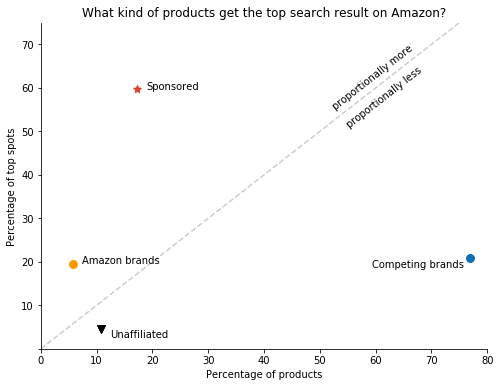

In [36]:
cats = [
    [
        'Sponsored'
    ],
    [
        'Amazon brands', 
        'Competing brands',
    ],
    [ 
        'Unaffiliated', 
    ],
]
plt.figure(figsize=(8, 6))
plt.title("What kind of products get the top search result on Amazon?")
ax = plt.gca()

for i, to_check in enumerate(cats):
    fn_out = f'../data/output/animation/fig_{i}.png'
    to_plot = res[res.Category.isin(to_check)]
    
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    ax.set_ylabel('Percentage of top spots')
    ax.set_xlabel('Percentage of products')

    ax.set_ylim(0, 75)
    ax.set_xlim(0, 80) 
    ax.yaxis.get_major_ticks()[0].label1.set_visible(False)
    
    for kind in to_check:
        d = to_plot[to_plot.Category==kind]
        if kind in ['Unaffiliated']:
            ax.annotate(kind, (d['Perc Products'] + 1.5,
                           d['Perc #1 spot'] - 2))
        elif kind == 'Competing brands':
            ax.annotate(kind, (d['Perc Products'] - 17.5,
                           d['Perc #1 spot'] - 2))
        else:
            ax.annotate(kind, (d['Perc Products'] + 1.6,
                               d['Perc #1 spot']))
        for j in range(1,6):
            plt.scatter(x=d['Perc Products'],
                        y=d['Perc #1 spot'],
                        c=cat2color[kind],
                        s=55,
                        alpha=.2 * j,
                        label=kind,
                        marker = mkr_dict[kind]['marker'])
           

            fn_out = f'../data/output/animation/fig_{i}_{j:02d}.png'
            plt.savefig(fn_out);
            
ax.plot([0, 100], [0, 100],  '--', alpha=.4, color='grey')
ax.annotate("proportionally more", 
            (52, 55), rotation=38)
ax.annotate("proportionally less", 
            (54.5, 51), rotation=38)
for j in range(7, 16):
    fn_out = f'../data/output/animation/fig_{i}_{j:02d}.png'
    plt.savefig(fn_out);

## Make GIF

In [37]:
import glob
from PIL import Image

# filepaths
fp_in = "../data/output/animation/*.png"
fp_out = "../data/output/animation/image.gif"

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=250, loop=0, optimize=True)

## Heatmap

In [38]:
control = (df.product_order.value_counts()
    .sort_index()
    .reindex(pd.RangeIndex(1, 61))[::-1])

In [39]:
def heatmap(df, control, cmap, title, vmin=0, vmax=100):
    """Produces a heatmap of product slots"""
    amazn_label = (df
        .product_order.value_counts()
        .sort_index()
        .reindex(pd.RangeIndex(1, 61))[::-1])
 
    amazn_label = amazn_label / control * 100
    
    amazn_label_grid = amazn_label.iloc[::-1].values.reshape(15, 4)
    # amazn_label_grid = (amazn_label / amazn_label.sum() * 100).iloc[::-1].values.reshape(15, 4)

    amazn_label_grid = pd.DataFrame(amazn_label_grid)
    amazn_label_grid.index = [_ + 1 for _ in amazn_label_grid.index]
    amazn_label_grid.columns = [_ + 1 for _ in amazn_label_grid.columns]

    fig = plt.figure(figsize=(6,12))
    sns.heatmap(amazn_label_grid,
                linewidths=4,
                fmt='g',
                cmap=cmap,
                vmin=vmax,
                vmax=vmin)
    plt.title(title)
    plt.ylabel("⟵ Rows of products going down the page")
    plt.xlabel("Columns of products across the page")
    plt.yticks(rotation=0)
    
    return fig

In [40]:
amazn_label = (df_amazon_brand_
    .product_order.value_counts()
    .sort_index()
    .reindex(pd.RangeIndex(1, 61)))

## the first spot is this many times more than every other position
amazn_label = amazn_label / control * 100
amazn_label[1] / amazn_label[1:59].mean()

3.532968501175046

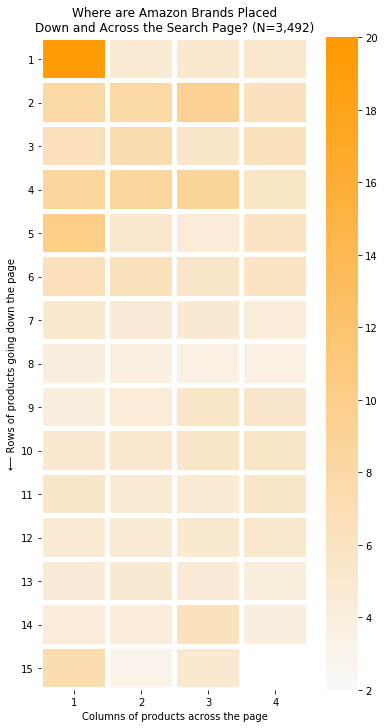

In [41]:
cmap = LinearSegmentedColormap.from_list(
    'mycmap', ['#f9f9f9', "#ff9900"]
)
fig = heatmap(
    df_amazon_brand_, control,
    cmap = LinearSegmentedColormap.from_list(None, ['#f9f9f9', "#ff9900"]),
    title=f"Where are Amazon Brands Placed\nDown and Across the Search Page? (N={n_samples:,})",
    vmax=20, vmin=2
)
fig.savefig(fig5a);

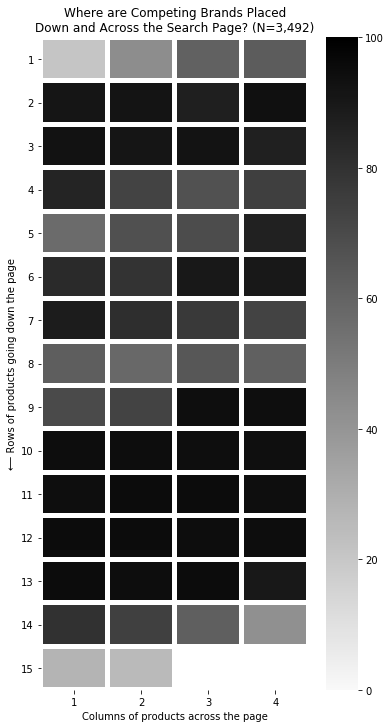

In [42]:
fig = heatmap(
    df_non_amazon, control,
    cmap = LinearSegmentedColormap.from_list(None, ['#f9f9f9', 'black']),
    title=f"Where are Competing Brands Placed\nDown and Across the Search Page? (N={n_samples:,})",
)
fig.savefig(fig5b)

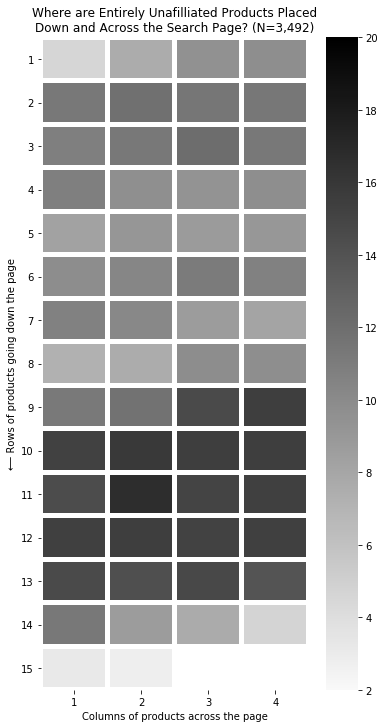

In [43]:
fig = heatmap(
    df_non_amazon_, control,
    cmap = LinearSegmentedColormap.from_list(None, ['#f9f9f9', 'black']),
    title=f"Where are Entirely Unafilliated Products Placed\nDown and Across the Search Page? (N={n_samples:,})",
    vmax=20, vmin=2
)
fig.savefig(fig5b)

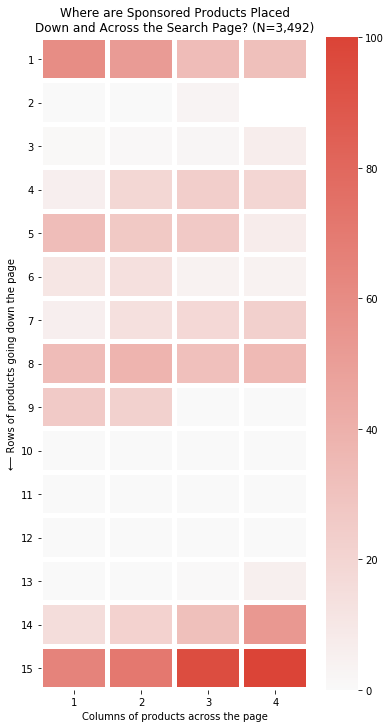

In [44]:
fig = heatmap(
    df_s, control, 
    cmap=LinearSegmentedColormap.from_list(None, ['#f9f9f9', '#DB4437']),
    title=f"Where are Sponsored Products Placed\nDown and Across the Search Page? (N={n_samples:,})"
)
fig.savefig(fig6a)

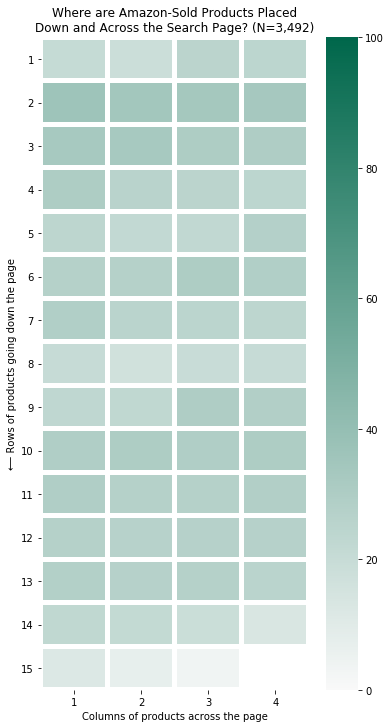

In [45]:
fig = heatmap(
    df_amazon_sold_, control, 
    cmap=LinearSegmentedColormap.from_list(None, ['#f9f9f9', '#00674b']),
    title=f"Where are Amazon-Sold Products Placed\nDown and Across the Search Page? (N={n_samples:,})"
)
fig.savefig(fig6b)

In [46]:
# summary statisics

In [47]:
unique_products = df.drop_duplicates('asin')
n_unique_products = unique_products.asin.nunique()

In [48]:
# what percentage of products are amazon
len(unique_products[unique_products.asin.isin(amazon_asin)]) / n_unique_products

0.04693525431545134

In [49]:
## Not Clearly Labelled

In [50]:
# How many asins are Featured from our brands
(df[df.is_featured_brand == True].asin.nunique() / 
df[df.asin.isin(amazon_asin)].asin.nunique())

0.26088429612061664

In [51]:
# How many asins are Featured from our brands
(len(df[df.is_featured_brand == True]) / 
len(df[df.asin.isin(amazon_asin)]))

0.1962855382448728

In [52]:
amazon_missed_all = '|'.join([
    'amazon basics',
    'amazon essentials',
    'whole foods market',
    'amazon commercial',
    'amazon collection',
    'amazon fresh',
    'amazon elements',
    'amazonbasics'
    '365 everyday value',
    'amazon exclusive',
    'amazon us exclusive',
    'amazon brand'
])

amazon_missed = '|'.join([
    'amazon basics',
    'amazon essentials',
    'whole foods market',
    'amazon commercial',
    'amazon collection',
    'amazon fresh',
    'amazon elements',
    'amazonbasics'
    '365 everyday value',
])

amazon_disclaimer = '|'.join([
    'amazon exclusive',
    'amazon us exclusive',
    'amazon brand'
])

In [53]:
# How many contain a disclaimer
(df[
  ((df.is_featured_brand) | 
   (df.product_name.str.contains(amazon_disclaimer, case=False))) &
  (df.asin.isin(amazon_asin))
].asin.nunique() / 

 df[df.asin.isin(amazon_asin)].asin.nunique())

0.4204641707606302

In [54]:
# how many items contains a name with known brand
(df[
  (df.product_name.str.contains(amazon_missed, case=False)) &
  (df.asin.isin(amazon_asin))
].asin.nunique() / 

 df[df.asin.isin(amazon_asin)].asin.nunique())

0.2475012705404032

In [55]:
# How many do not contain a disclaimer
1- (df[
  ((df.product_name.str.contains(amazon_missed_all, case=False)) | 
   (df.is_featured_brand)) &
  (df.asin.isin(amazon_asin))
].asin.nunique() / 

 df[df.asin.isin(amazon_asin)].asin.nunique())

0.4089446044384212

In [56]:
# perc of top amazon products with a "featured from our brands" tag
(df[
    (df.is_featured_brand) &
    (df.asin.isin(amazon_asin)) &
    (df.product_order == 1)
].search_term.nunique()) / df[(df.asin.isin(amazon_asin)) & (df.product_order == 1)].search_term.nunique()

0.8387978142076503

## More Stars and reviews?

In [57]:
if not os.path.exists(fn_compare):   
    data = []
    for st, _df in tqdm(df[df.is_sponsored == False].groupby("search_term")):
        _df.sort_values(by='product_order')
        amzn = _df[_df.asin.isin(amazon_asin)]
        non_amzn = _df[~_df.asin.isin(amazon_asin)]
        wnon_amzn =_df[
            (~_df.asin.isin(amazon_asin)) &
            (_df.is_sold_by_amazon == False) &
            (_df.is_fresh == False) &
            (_df.is_prime == False)
        ]

        if not amzn.empty:
            top_amazon =  amzn.product_order.iloc[0]
            amazon_star = amzn.stars.iloc[0]
            amazon_review = amzn.reviews.iloc[0]
        else:
            top_amazon = np.nan
            amazon_star = np.nan
            amazon_review = np.nan

        if not non_amzn.empty:    
            top_non_amazon_brand = non_amzn.product_order.iloc[0]
            non_amazon_star = non_amzn.stars.iloc[0]
            non_amazon_review = non_amzn.reviews.iloc[0]
        else:
            top_non_amazon = np.nan
            non_amazon_star = np.nan
            non_amazon_review = np.nan

        if not wnon_amzn.empty:
            top_wnon_amazon = wnon_amzn.product_order.iloc[0]
            wnon_amazon_star = wnon_amzn.stars.iloc[0]
            wnon_amazon_review = wnon_amzn.reviews.iloc[0]

        else:
            top_wnon_amazon = np.nan
            wnon_amazon_star = np.nan
            wnon_amazon_review = np.nan
        record = {
            "search_term": st,
            "position_first_amazon": top_amazon,
            "position_first_non_amazon": top_non_amazon_brand,
            "position_first_wholly_non_amazon": top_wnon_amazon,

            "amazon_stars": amazon_star,
            "amazon_reviews": amazon_review,

            "non_amazon_stars": non_amazon_star,
            "non_amazon_reviews": non_amazon_review,

            "wnon_amazon_stars": wnon_amazon_star,
            "wnon_amazon_reviews": wnon_amazon_review,
        }
        data.append(record)
    df_compare = pd.DataFrame(data)
    df_compare.to_csv(fn_compare, index=False)
    
else:
    df_compare = pd.read_csv(fn_compare)

100%|██████████| 3492/3492 [05:28<00:00, 10.62it/s]


In [58]:
df_compare = pd.DataFrame(data)

In [59]:
len(df_compare[df_compare.position_first_amazon < df_compare.position_first_non_amazon]) / len(df_compare)

0.22880870561282932

In [60]:
# how many Amazon products have more stars
df_compare[
    df_compare.position_first_amazon < df_compare.position_first_non_amazon
].apply(
    lambda x:
    x['amazon_stars'] > x['non_amazon_stars'],
    axis=1
).value_counts(normalize=True)

False    0.653317
True     0.346683
dtype: float64

In [61]:
# how many Amazon products have more reivews than the
df_compare[
    (df_compare.position_first_amazon < df_compare.position_first_non_amazon) &
    (~df_compare.non_amazon_reviews.isnull())
].apply(
    lambda x:
    x['amazon_reviews'] > x['non_amazon_reviews'],
    axis=1
).value_counts(normalize=True)

False    0.509579
True     0.490421
dtype: float64

In [62]:
# how many Amazon products have more reivews than the
df_compare[
    (df_compare.position_first_amazon < df_compare.position_first_non_amazon) &
    (~df_compare.non_amazon_reviews.isnull())
].apply(
    lambda x:
    (x['amazon_reviews'] < x['non_amazon_reviews']) and 
    (x['amazon_stars'] < x['non_amazon_stars']),
    axis=1
).value_counts(normalize=True)

False    0.798212
True     0.201788
dtype: float64

In [63]:
# duplicates
asins_by_search = df[df.is_sponsored == False].groupby('search_term').asin.value_counts()

In [64]:
# perc_searches_dupluicate_asin
asins_by_search[asins_by_search > 1].index.get_level_values(0).nunique() / df.search_term.nunique()

0.09221076746849943

In [65]:
# how many of these duplicates are Amazon products?
duplicate_asin = asins_by_search[asins_by_search > 1].index.get_level_values(1)
len([_ for _ in duplicate_asin if _ in amazon_asin]) / len(duplicate_asin)

1.0

## Supplementary dataset

In [66]:
df_generic.search_term.nunique()

1217

In [67]:
table_generic = calculate_table_not_unique(df_generic, amazon_asin)
table_generic

,Category,Perc Products,Perc #1 spot,Perc first row
0,Unaffiliated,4.143634,1.068200,5.012325
1,Amazon brands,8.225208,24.897288,35.332786
2,Competing brands,73.530388,10.764174,54.478225
3,Sponsored,18.244404,64.338537,84.223500
4,Amazon sold,25.382828,21.857025,45.193098
5,Third-party sold,56.372768,13.804437,48.808546
6,Amazon shipped,77.500830,34.511093,70.008217


In [68]:
table_top = calculate_table_not_unique(df_top, amazon_asin)
table_top

,Category,Perc Products,Perc #1 spot,Perc first row
0,Unaffiliated,10.852965,4.553265,14.977090
1,Amazon brands,5.801081,19.530355,24.770905
2,Competing brands,76.880992,20.819015,63.516609
3,Sponsored,17.317926,59.650630,75.286369
4,Amazon sold,25.549500,20.733104,44.186712
5,Third-party sold,57.132573,19.616266,51.718213
6,Amazon shipped,71.672870,35.595647,70.217640


In [69]:
df[df.is_amazon == True].asin.nunique() / df[(df.product_order == 1) & (df.is_amazon == True)].search_term.nunique()

8.064207650273223

In [70]:
df[df.is_amazon != True].asin.nunique() / df[(df.product_order == 1) & (df.is_amazon != True)].search_term.nunique()

43.42971014492753

In [71]:
df[(df.product_order == 1) & (df.is_amazon == True)].search_term.nunique()

732

In [72]:
table_diff = table_generic.set_index('Category').subtract(
    table_top.set_index('Category'))

In [73]:
comparison = pd.concat([
    table_top[['Category', 'Perc Products',  'Perc #1 spot', 'Perc first row']].set_index('Category'), 
    table_generic[['Category','Perc Products',  'Perc #1 spot', 'Perc first row']].set_index('Category'),
], axis=1, keys=["top", "generic"])

In [74]:
comparison = comparison.swaplevel(0, 1, 1).sort_index(1)

In [75]:
comparison

Perc #1 spot            Perc Products             \
                      generic        top       generic        top   
Category                                                            
Unaffiliated         1.068200   4.553265      4.143634  10.852965   
Amazon brands       24.897288  19.530355      8.225208   5.801081   
Competing brands    10.764174  20.819015     73.530388  76.880992   
Sponsored           64.338537  59.650630     18.244404  17.317926   
Amazon sold         21.857025  20.733104     25.382828  25.549500   
Third-party sold    13.804437  19.616266     56.372768  57.132573   
Amazon shipped      34.511093  35.595647     77.500830  71.672870   

                 Perc first row             
                        generic        top  
Category                                    
Unaffiliated           5.012325  14.977090  
Amazon brands         35.332786  24.770905  
Competing brands      54.478225  63.516609  
Sponsored             84.223500  75.286369  
Amazon sold           45.193098  44.186712  
Third-party sold      48.808546  51.718213  
Amazon shipped        70.008217  70.217640

In [76]:
comparison.round(1).to_csv(table1)

## Sankey

In [77]:
print(json.dumps({
    "nodes":[
        {"name":"All Products","node":0},
        {"name":"Sponsored","node":1},   
        {"name":"Non-Sponsored","node":2},   
        {"name":"Sold by Amazon","node":3},
        {"name":"Not Sold by Amazon","node":4},
        {"name":"Amazon Product","node":5},
        {"name":"Not Amazon Product","node":6}
    ],
    "links":[
        {"source":0,"target":1,"value":len(df_s)},
        {"source":0,"target":2,"value":len(df_ns)},  
        {"source":2,"target":3,"value":len(df_amazon_sold_)},
        {"source":2,"target":4,"value":len(df_not_amazon_sold_)},    
        {"source":3,"target":5,"value":len(df_amazon_sold_[df_amazon_sold_.asin.isin(amazon_asin)])},
        {"source":3,"target":6, "value":len(df_amazon_sold_[~df_amazon_sold_.asin.isin(amazon_asin)])},
        {"source":4,"target":5,"value":len(df_not_amazon_sold_[df_not_amazon_sold_.asin.isin(amazon_asin)])},
        {"source":4,"target":6,"value":len(df_not_amazon_sold_[~df_not_amazon_sold_.asin.isin(amazon_asin)])},
    ]
}))

{"nodes": [{"name": "All Products", "node": 0}, {"name": "Sponsored", "node": 1}, {"name": "Non-Sponsored", "node": 2}, {"name": "Sold by Amazon", "node": 3}, {"name": "Not Sold by Amazon", "node": 4}, {"name": "Amazon Product", "node": 5}, {"name": "Not Amazon Product", "node": 6}], "links": [{"source": 0, "target": 1, "value": 32477}, {"source": 0, "target": 2, "value": 155057}, {"source": 2, "target": 3, "value": 47914}, {"source": 2, "target": 4, "value": 107143}, {"source": 3, "target": 5, "value": 8265}, {"source": 3, "target": 6, "value": 39649}, {"source": 4, "target": 5, "value": 2614}, {"source": 4, "target": 6, "value": 104529}]}


## Error check

In [78]:
check_asin = df[
    (df.is_amazon == True) &
    (df.is_sold_by_amazon == False)
]

In [79]:
fn_amazon = '../data/intermediary/amazon_private_label.csv.gz'

In [80]:
df_amazon[df_amazon.asin.isin(check_asin.asin)].source.value_counts()

AttributeError: 'DataFrame' object has no attribute 'source'

In [ ]:
value_counts(check_asin.drop_duplicates('asin').merge(
    df_amazon, on='asin', how='left'
), 'source', dropna=False)

In [ ]:
to_check = check_asin.drop_duplicates('asin').merge(
    df_amazon, on='asin', how='left'
)

In [ ]:
to_check= to_check[to_check.source == 'text search']

In [ ]:
to_check.sold_by.value_counts(dropna=False)

In [ ]:
to_check.to_csv('../data/intermediary/spot_check/text_search_asins_2021-5-4.csv', index=False)

In [ ]:
to_check.to_csv('../data/intermediary/spot_check/all_outlier_asins_2021-5-4.csv', index=False)

In [ ]:
"B07MC98SZH" in amazon_asin

In [ ]:
len(df[df.is_amazon == True]) / len(df)

In [ ]:
__df_search = df_search[
    (df_search.search_term.isin(searches_with_amazon_brands)) & 
    (df_search.search_term.isin(top_searches))
].merge(df_products, how='left')

In [ ]:
__df_search.product_type.value_counts()

In [ ]:
def carousel_correction(row):
    if row['product_type'] == 'featured_brands_carousel':
        return True
    else:
        return row['is_amazon']

In [ ]:
__df_search["is_amazon"] = __df_search.apply(carousel_correction, axis=1)

In [ ]:
[
    'editorial_recs_carousel',
    'sponsored_banner',
    'misc_carousel',
    'regular_placement__missed '
]

In [ ]:
calculate_table(__df_search, amazon_asin=amazon_asin)

In [ ]:
calculate_table(df, amazon_asin=amazon_asin)